In [1]:
#Useful ibrarires and functions
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import trange
from IPython.display import Video

from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.arena import FlatTerrain
from flygym.mujoco.examples.common import PreprogrammedSteps
from flygym.mujoco.examples.cpg_controller import CPGNetwork

from gymnasium import spaces
import cv2

In [2]:
#Implementing a standard tripod gait for the walk
#Taken from exercices sessions.
_tripod_phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
_tripod_coupling_weights = (_tripod_phase_biases > 0) * 10

In [3]:
#Implementing a windy arena with a laminar wind
from dm_control.mjcf.physics import Physics


class WindArena(FlatTerrain):
    def __init__(
        self,

        #Change wind direction here
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        wind_vector=[ -1, -3, 0],
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        medium_density=0.01,
        medium_viscosity=0.01,
        **kwargs
    ):
        super().__init__(**kwargs)
        self._add_wind(wind_vector, medium_density, medium_viscosity)
        self.wind_vector = wind_vector

    def _add_wind(self, wind_vector, medium_density, medium_viscosity):
        # Here we directly change the fields of the xml option element
        self.root_element.option.__setattr__("density", medium_density)
        self.root_element.option.__setattr__("viscosity", medium_viscosity)
        self.root_element.option.__setattr__("wind", wind_vector)
    

wind_arena = WindArena()

In [4]:
from typing import Any, Dict, Tuple

#Create a NeuromechFly Class with a fly that will be able to follow the wind in a windy area
class WindTurningNMF(NeuroMechFly):
    def __init__(
        self,
        preprogrammed_steps=None,
        intrinsic_freqs=np.ones(6) * 12,
        intrinsic_amps=np.ones(6) * 1,
        phase_biases=_tripod_phase_biases,
        coupling_weights=_tripod_coupling_weights,
        convergence_coefs=np.ones(6) * 20,
        init_phases=None,
        init_magnitudes=None,
        amplitude_range=(-0.5, 1.5),
        seed=0,
        **kwargs,
    ):
        # Initialize core NMF simulation
        super().__init__(**kwargs)

        if preprogrammed_steps is None:
            preprogrammed_steps = PreprogrammedSteps()
        self.preprogrammed_steps = preprogrammed_steps
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.phase_biases = phase_biases
        self.coupling_weights = coupling_weights
        self.convergence_coefs = convergence_coefs
        self.amplitude_range = amplitude_range

        # Define action and observation spaces
        self.action_space = spaces.Box(*amplitude_range, shape=(2,))

        # Initialize CPG network
        self.cpg_network = CPGNetwork(
            timestep=self.sim_params.timestep,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=seed,
        )
        self.cpg_network.reset(init_phases, init_magnitudes)
    
    #Here we can change the stiffness and damping of the aristae
    def _set_joints_stiffness_and_damping(self):
        for joint in self.model.find_all("joint"):
            if joint.name in self.actuated_joints:
                joint.stiffness = self.sim_params.joint_stiffness
                joint.damping = self.sim_params.joint_damping
            elif "LArista" in joint.name:
                joint.stiffness = 0.006
                joint.damping = 2e-4
            elif "RArista" in joint.name:
                joint.stiffness = 0.006
                joint.damping = 2e-4
            elif "Head" in joint.name:
                joint.stiffness = 1000.0
                joint.damping = 1000.0
            else:
                joint.stiffness = self.sim_params.non_actuated_joint_stiffness
                joint.damping = self.sim_params.non_actuated_joint_damping

    #Here we add sensors on the aristae       
    def _add_joint_sensors(self):
        self._arista_sensors = []
        self._debug_end_effectors = []

        for side in "LR":
            arista_sensor_joint = self.model.sensor.add(
                "jointpos", name=f"jointpos_{side}Arista", joint=f"joint_{side}Arista"
            )
            arista_sensor_torque = self.model.sensor.add(
                "jointactuatorfrc", name=f"jointactuatorfrc_{side}Arista", joint=f"joint_{side}Arista"
            )
            self._arista_sensors.append(arista_sensor_torque)
            self._arista_sensors.append(arista_sensor_joint)            

        return super()._add_joint_sensors()
    

    #Retrieve the observations of the newly added sensors
    def get_observation(self):
        obs = super().get_observation()
        arista_obs = self.physics.bind(self._arista_sensors).sensordata
        obs["arista_joint_pos"] = arista_obs.copy()
        obs["arista_joint_pos_filtered"] = arista_obs.copy()
        body_pos = self.physics.bind(self._body_sensors).sensordata
        obs["body_pos"] = body_pos.copy()        
        
        return obs
    
    #Define the observation spcae
    def _define_observation_space(self):
        _observation_space = {
            "joints": spaces.Box(
                low=-np.inf, high=np.inf, shape=(3, len(self.actuated_joints))
            ),
            "fly": spaces.Box(low=-np.inf, high=np.inf, shape=(4, 3)),
            "contact_forces": spaces.Box(
                low=-np.inf, high=np.inf, shape=(len(self.contact_sensor_placements), 3)
            ),
            # x, y, z positions of the end effectors (tarsus-5 segments)
            "end_effectors": spaces.Box(low=-np.inf, high=np.inf, shape=(6, 3)),
            "fly_orientation": spaces.Box(low=-np.inf, high=np.inf, shape=(3,)),
            "arista_joint_pos": spaces.Box(low=-np.inf, high=np.inf, shape=(4,)),
            "arista_joint_pos_filtered": spaces.Box(low=-np.inf, high=np.inf, shape=(4,))
        }
        if self.sim_params.enable_vision:
            _observation_space["vision"] = spaces.Box(
                low=0,
                high=255,
                shape=(2, self._mujoco_config["vision"]["num_ommatidia_per_eye"], 2),
            )
        if self.sim_params.enable_olfaction:
            _observation_space["odor_intensity"] = spaces.Box(
                low=0,
                high=np.inf,
                shape=(self.arena.odor_dimensions, len(self._antennae_sensors)),
            )
        return spaces.Dict(_observation_space)

    def reset(self, seed=None, init_phases=None, init_magnitudes=None, **kwargs):
        obs, info = super().reset(seed=seed)
        self.cpg_network.random_state = np.random.RandomState(seed)
        self.cpg_network.intrinsic_amps = self.intrinsic_amps
        self.cpg_network.intrinsic_freqs = self.intrinsic_freqs
        self.cpg_network.reset(init_phases, init_magnitudes)
        #Reset the obs by hand
        obs["arista_joint_pos"] = np.zeros((4,))
        return obs, info

    #Step function taken for the exercices for turning modulation
    def step(self, action):
        """Step the simulation forward one timestep.

        Parameters
        ----------
        action : np.ndarray
            Array of shape (2,) containing descending signal encoding
            turning.
        """
        # update CPG parameters
        amps = np.repeat(np.abs(action[:, np.newaxis]), 3, axis=1).flatten()
        freqs = self.intrinsic_freqs.copy()
        freqs[:3] *= 1 if action[0] > 0 else -1
        freqs[3:] *= 1 if action[1] > 0 else -1
        self.cpg_network.intrinsic_amps = amps
        self.cpg_network.intrinsic_freqs = freqs

        self.cpg_network.step()

        joints_angles = []
        adhesion_onoff = []
        for i, leg in enumerate(self.preprogrammed_steps.legs):
            # get target angles from CPGs and apply correction
            my_joints_angles = self.preprogrammed_steps.get_joint_angles(
                leg,
                self.cpg_network.curr_phases[i],
                self.cpg_network.curr_magnitudes[i],
            )
            joints_angles.append(my_joints_angles)

            # get adhesion on/off signal
            my_adhesion_onoff = self.preprogrammed_steps.get_adhesion_onoff(
                leg, self.cpg_network.curr_phases[i]
            )
            adhesion_onoff.append(my_adhesion_onoff)

        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        return super().step(action)

windturning_nmf = WindTurningNMF(Parameters())
windturning_nmf._arista_sensors

[MJCF Element: <jointactuatorfrc name="jointactuatorfrc_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointpos name="jointpos_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointactuatorfrc name="jointactuatorfrc_RArista" joint="joint_RArista"/>,
 MJCF Element: <jointpos name="jointpos_RArista" joint="joint_RArista"/>]

In [5]:
#Declare simulation parameters

run_time = 15

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_top",
    render_playspeed=0.5,
    enable_adhesion=True
)

nmf = WindTurningNMF(
    sim_params = sim_params,
    arena = wind_arena,
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0,0,0.2),
)

In [6]:
#Run the simulation
obs_list = []
magnitude_hist = []
end_effector_L = []
end_effector_R = []

AverageWindowL = np.array([])
AverageWindowR = np.array([])

target_num_steps = int(run_time / nmf.timestep)

obs, info = nmf.reset(seed=0)

for i in trange(target_num_steps) :
    curr_time = i * nmf.sim_params.timestep 

    #The aristae joint posed will be averaged through a sliding window to obtain a smoother signal
    AverageWindowL=np.append(AverageWindowL,obs["arista_joint_pos"][1])
    AverageWindowR=np.append(AverageWindowR,obs["arista_joint_pos"][3])

    if(len(AverageWindowL)>=2000):
       AverageWindowL=np.delete(AverageWindowL,0)
       AverageWindowR=np.delete(AverageWindowR,0)

    obs["arista_joint_pos_filtered"][1]=np.mean(AverageWindowL)
    obs["arista_joint_pos_filtered"][3]=np.mean(AverageWindowR)

    L = obs["arista_joint_pos_filtered"][1]
    R = obs["arista_joint_pos_filtered"][3]

    #The fly walk straight or starts turning if a bias indicating wind is sensed in the antenae
    if((L-R)>0.005) :
        action=np.array([1, 0.2])
    elif((R-L)>0.005) :
        action=np.array([0.2, 1])
    else :
        action = np.array([1, 1])

    
    
    obs, reward, terminated, truncated, info = nmf.step(action)

    obs_list.append(obs)    

    end_effector_L.append(nmf.physics.named.data.qpos[f"Animat/joint_LArista"].copy())
    end_effector_R.append(nmf.physics.named.data.qpos[f"Animat/joint_RArista"].copy())
    magnitude_hist.append(nmf.cpg_network.curr_magnitudes.copy())

    nmf.render()



  0%|          | 0/150000 [00:00<?, ?it/s]

100%|██████████| 150000/150000 [08:14<00:00, 303.33it/s]


In [7]:
#Save the video
title = "Video Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]"
nmf.save_video(("outputs/"+title + "_NONE.mp4"), 0)

In [8]:
#Play the video
Video(("outputs/"+title + "_NONE.mp4"))

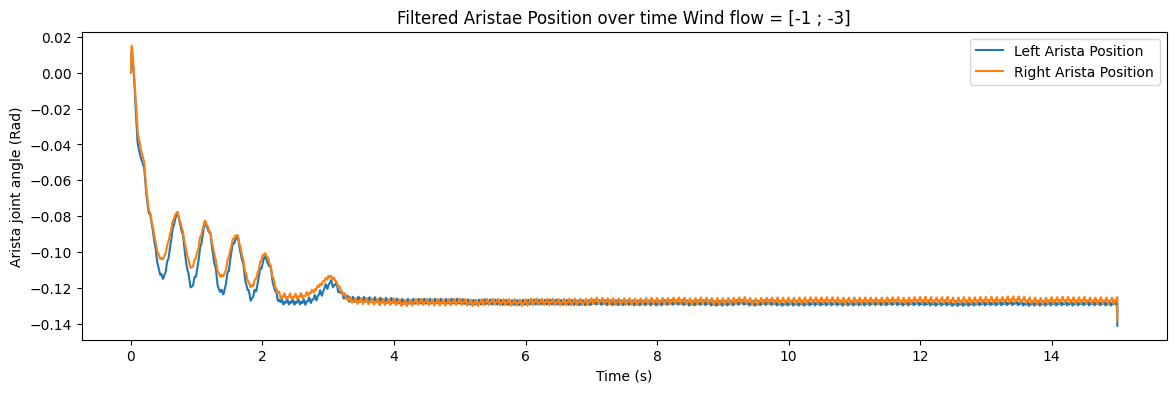

In [9]:
#Plot the aristae position over time

arista_joint_filtered = np.array([obs["arista_joint_pos_filtered"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps) 
fig, ax1 = plt.subplots(figsize=(14, 4))


ax1.plot(time, arista_joint_filtered[:, 1], label="Left Arista Position")
ax1.plot(time, arista_joint_filtered[:, 3], label="Right Arista Position")
ax1.set_ylabel('Arista joint angle (Rad)')
ax1.set_xlabel('Time (s)')
ax1.legend(loc='best')
title = "Filtered Aristae Position over time Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]"
plt.title(title)
plt.savefig("outputs/"+title+"_NONE.png",dpi=160)

plt.show()

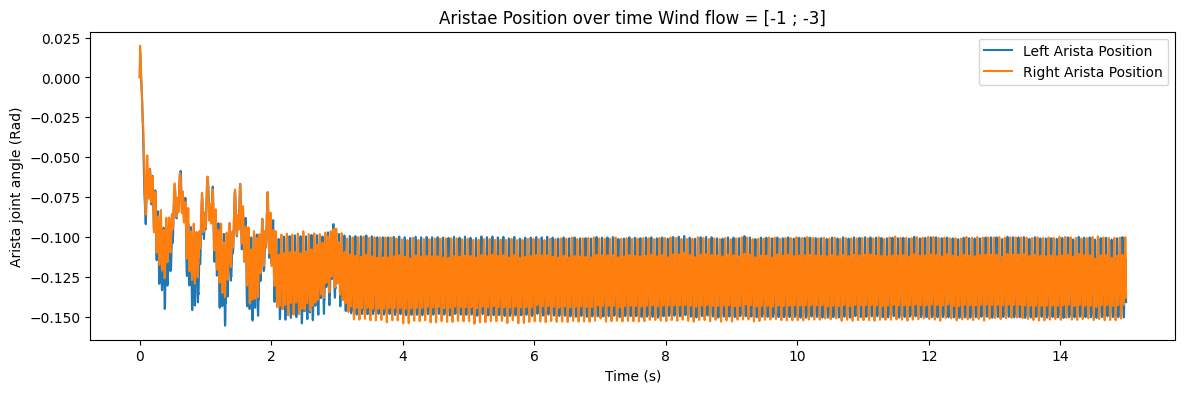

In [10]:
#Plot the filtered aristae position over time

arista_joint = np.array([obs["arista_joint_pos"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps) 

fig, ax1 = plt.subplots(figsize=(14, 4))

ax1.plot(time, arista_joint[:, 1], label="Left Arista Position")
ax1.plot(time, arista_joint[:, 3], label="Right Arista Position")
ax1.set_ylabel('Arista joint angle (Rad)')
ax1.set_xlabel('Time (s)')
ax1.legend(loc='best')

title = "Aristae Position over time Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]"
plt.title(title)
plt.savefig("outputs/"+title+"_NONE.png",dpi=160)
plt.show()

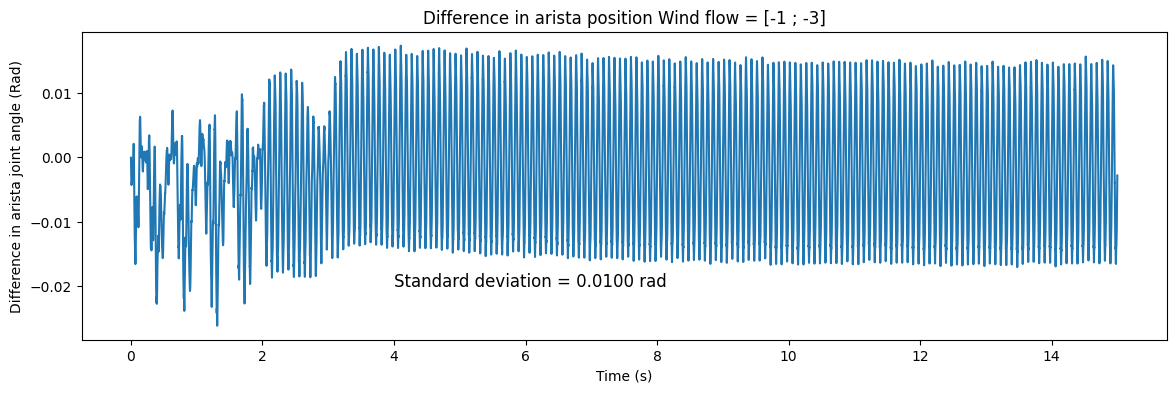

In [19]:
#Plot the difference of position across aristae.
plt.figure(figsize=(14,4))

plt.plot(time,(np.array(arista_joint[:, 1]) - np.array(arista_joint[:, 3])))
title = ("Difference in arista position Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]")
plt.title(title)
plt.xlabel('Time (s)')
plt.ylabel('Difference in arista joint angle (Rad)')

std=np.std(np.array(arista_joint[:, 1]) - np.array(arista_joint[:, 3]))
plt.text(4,-0.02, "Standard deviation = "+ str(std)[:6] +" rad" ,fontsize = 12)

plt.savefig("outputs/"+title+"_NONE.png",dpi=160)

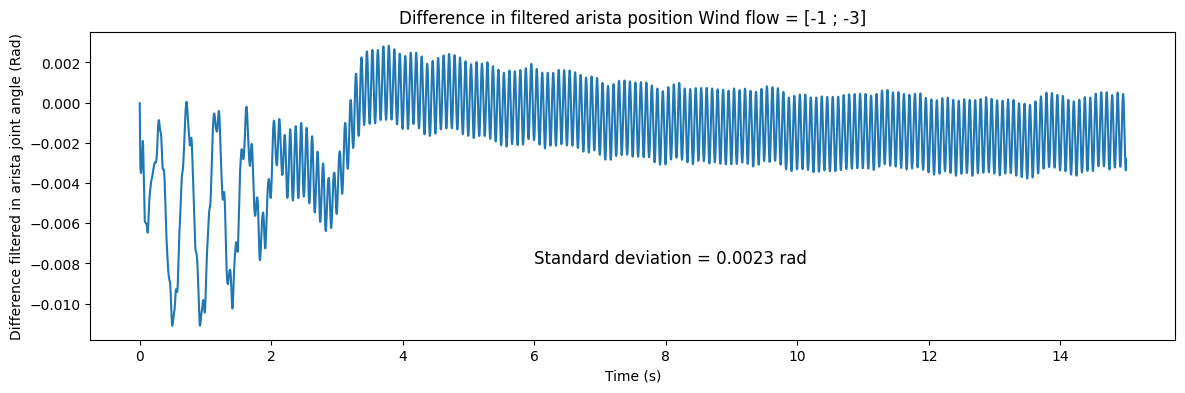

In [20]:
#Plot the filtered difference of position across aristae.
plt.figure(figsize=(14,4))
plt.plot(time,(np.array(arista_joint_filtered[:, 1]) - np.array(arista_joint_filtered[:, 3])))
title = ("Difference in filtered arista position Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]")
plt.title(title)
plt.xlabel('Time (s)')
plt.ylabel('Difference filtered in arista joint angle (Rad)')

std=np.std(np.array(arista_joint_filtered[:, 1]) - np.array(arista_joint_filtered[:, 3]))
plt.text(6,-0.008, "Standard deviation = "+ str(std)[:6] +" rad" ,fontsize = 12)

plt.savefig("outputs/"+title+"_NONE.png",dpi=160)

In [23]:
#Compute assessment metrics using the slope of the wind and the fly's position & heading direction
wind_slope = wind_arena.wind_vector[1] / wind_arena.wind_vector[0]

def calculate_angle(slope1, slope2):
    tan_theta = abs((slope1 - slope2) / (1 + slope1 * slope2))
    theta_radians = math.atan(tan_theta)
    theta_degrees = math.degrees(theta_radians)
    return theta_degrees

wind_dir =  math.radians(calculate_angle(0,wind_slope)) + np.pi/2

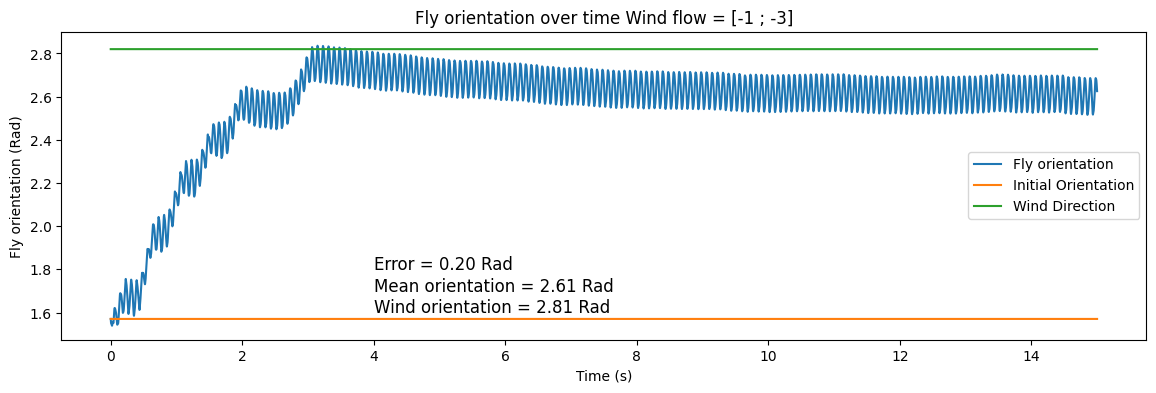

In [25]:
#Plot fly orientation with respect to wind direction

plt.figure(figsize=(14,4))

fly = np.array([obs["fly"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps) 
fly_orient_x = fly[:,2,0]
plt.plot(time,fly_orient_x)
initial_orient = np.ones(fly_orient_x.shape )*fly[0,2,0]


plt.plot(time,initial_orient)
plt.plot(time,np.ones(len(time))*wind_dir)
plt.legend(("Fly orientation","Initial Orientation","Wind Direction"))
title = ("Fly orientation over time Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]")
plt.title(title)
plt.ylabel("Fly orientation (Rad)")
plt.xlabel("Time (s)")

#Mean value is computed only using a portion of the last observations
mean_orient_final = np.mean(fly[80000:,2,0])

plt.text(4,1.6, "Wind orientation = "+ str(wind_dir)[:4] +" Rad" ,fontsize = 12)
plt.text(4,1.7, "Mean orientation = "+ str(mean_orient_final)[:4] +" Rad" ,fontsize = 12)
plt.text(4,1.8, "Error = "+ str(np.abs(wind_dir-mean_orient_final))[:4] +" Rad" ,fontsize = 12)

plt.savefig("outputs/"+title+"_NONE.png",dpi=160)

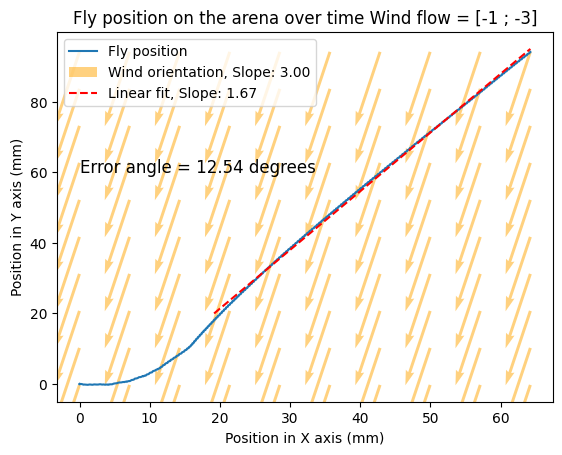

In [27]:
#Plot the position of the fly on the arena over time with a linear fit and measure of error

body_pos = np.array([obs["body_pos"] for obs in obs_list])
plt.plot(body_pos[:,0], body_pos[:,1])
title = ("Fly position on the arena over time Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]")

x_min, x_max = np.min(body_pos[:,0]), np.max(body_pos[:,0])
y_min, y_max = np.min(body_pos[:,1]), np.max(body_pos[:,1])
x, y = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))

# Define the vector field components
u = wind_arena.wind_vector[0] * np.ones_like(x)
v = wind_arena.wind_vector[1] * np.ones_like(y) 
plt.quiver(x, y, u, v, color = 'orange', alpha=0.5, scale=20)

# Make a linear fit when the fly locks on target position
slope, intercept = np.polyfit(body_pos[40000:,0], body_pos[40000:,1], 1)

# Measure of error between movement and wind direction

x=np.linspace(body_pos[40000,0],body_pos[-1,0],target_num_steps)
plt.plot(x,slope *x +intercept,'r--')

plt.xlabel("Position in X axis (mm)")
plt.ylabel("Position in Y axis (mm)")
plt.legend(("Fly position","Wind orientation, Slope: " +str( "%.2f" % wind_slope),"Linear fit, Slope: " + str( "%.2f" % slope) ))
plt.text(0,60, "Error angle = "+ ("%.2f" % (calculate_angle(slope,wind_slope))) + " degrees",fontsize = 12)
plt.title(title)
plt.savefig("outputs/"+title+"_NONE.png",dpi=160)

In [16]:
#Apply an arrow to the video showing the wind direction
title = "Video Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]"

cap = cv2.VideoCapture("outputs/"+title + ".mp4")
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
fps = cap.get(cv2.CAP_PROP_FPS) 
normalised_arrow = wind_arena.wind_vector[0:2]/np.linalg.norm(wind_arena.wind_vector[0:2])
   
size = (frame_width, frame_height)
out = cv2.VideoWriter(('outputs/Arrow ' + title + '.mp4'), cv2.VideoWriter_fourcc(*'XVID'), fps, size)

In [17]:
while(True): 
      
    # Reading from frame 
    ret,frame = cap.read() 
    if ret: 

        cv2.arrowedLine(
            frame,
            (int(frame_width/2), int(frame_height/2)),
            # Need to invert sign of y coordinate as the zero is on top
            (int(frame_width/2+30*wind_arena.wind_vector[0]), int(frame_height/2-30*wind_arena.wind_vector[1])),
            color=(0, 0, 255),
            thickness=2,
            tipLength=0.1,
        )

        # Save all frames as a video
        out.write(frame)
    else: 
        break

# Release all space and windows once done 
cap.release() 
out.release()
cv2.destroyAllWindows()

### The video with the arrow cannot be displayed in jupyter notebook open it from the outputs folder.

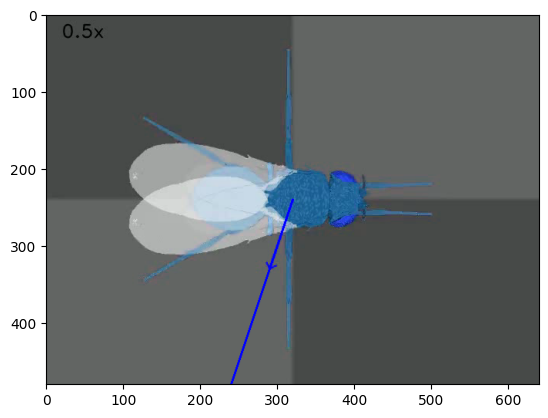

In [18]:
cap = cv2.VideoCapture('outputs/Arrow '+ title + '.mp4')
ret,frame = cap.read() 
cv2.arrowedLine(
            frame,
            (int(frame_width/2), int(frame_height/2)),
            # Need to invert sign of y coordinate as the referential is the opposite with 0 on top
            (int(frame_width/2+100*wind_arena.wind_vector[0]), int(frame_height/2-100*wind_arena.wind_vector[1])),
            color=(0, 0, 255),
            thickness=2,
            tipLength=0.1,
        )
plt.imshow(frame)